In [1]:
import pandas as pd
from datasets import Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
import matplotlib.pyplot as plt

In [2]:
# load processed data
df = pd.read_parquet("processed_data.parquet")

def preprocess_function(examples):
    # BART does not require special token for input
    inputs = [desc for desc in examples["norm_desc"]]
    targets = examples["norm_title"]
    return {"input_text": inputs, "target_text": targets}

# convert to Hugging Face Dataset
raw_dataset = Dataset.from_pandas(df[["norm_desc", "norm_title"]])
dataset = raw_dataset.map(preprocess_function, batched=True)

# split dataset
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

Map:   0%|          | 0/112390 [00:00<?, ? examples/s]

In [3]:
# load BART model and tokenizer
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

In [4]:
# define tokenize function
def tokenize_function(examples):
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=256,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["target_text"],
            max_length=32,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# tokenize dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/89912 [00:00<?, ? examples/s]

C:\Users\jinch\anaconda3\envs\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/22478 [00:00<?, ? examples/s]

In [5]:
# hyperparameters
training_args = Seq2SeqTrainingArguments(
    output_dir="./bart-news-title-generation",
    num_train_epochs=10,  
    per_device_train_batch_size=128,  
    per_device_eval_batch_size=128,
    learning_rate=3e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    predict_with_generate=True,  # 启用生成评估
    generation_max_length=32,    # 生成标题最大长度
    fp16=True,                   # 混合精度训练
)

# initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

trainer.train()

C:\Users\jinch\AppData\Local\Temp\ipykernel_24788\1109593025.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
C:\Users\jinch\anaconda3\envs\myenv\Lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss
1,1.846200,0.928348
2,1.025700,0.885303
3,0.913700,0.862758
4,0.877100,0.849653
5,0.827900,0.841192
6,0.801700,0.835964
7,0.789400,0.829776
8,0.763500,0.828194
9,0.751000,0.827442
10,0.741800,0.828300


C:\Users\jinch\anaconda3\envs\myenv\Lib\site-packages\transformers\modeling_utils.py:2810: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=7030, training_loss=0.9047761284948922, metrics={'train_runtime': 3055.6035, 'train_samples_per_second': 294.253, 'train_steps_per_second': 2.301, 'total_flos': 1.370565610831872e+17, 'train_loss': 0.9047761284948922, 'epoch': 10.0})

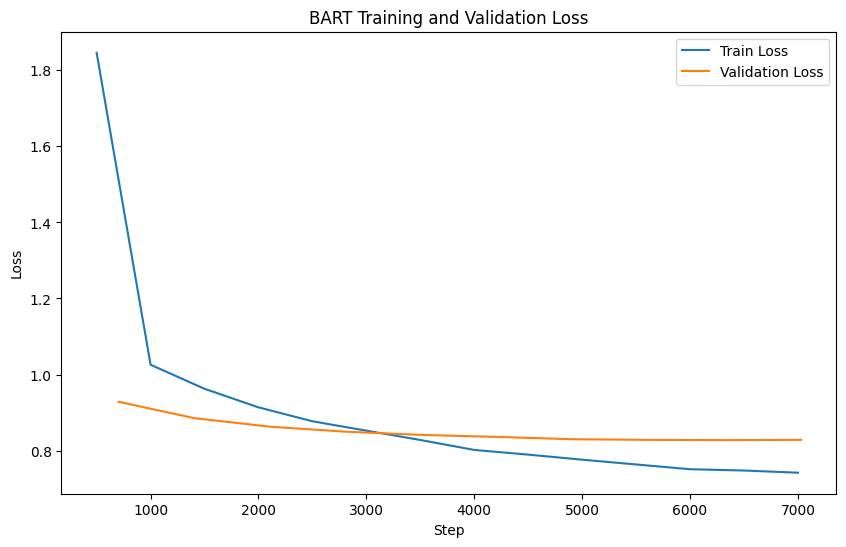

In [6]:
# plot training and validation loss
log_history = trainer.state.log_history
train_losses = [entry["loss"] for entry in log_history if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
steps_train = [entry["step"] for entry in log_history if "loss" in entry]
steps_eval = [entry["step"] for entry in log_history if "eval_loss" in entry]

plt.figure(figsize=(10, 6))
plt.plot(steps_train, train_losses, label="Train Loss")
plt.plot(steps_eval, eval_losses, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("BART Training and Validation Loss")
plt.legend()
plt.show()

In [7]:
# generate title
def generate_title(text):
    inputs = tokenizer(
        text,
        max_length=256,
        truncation=True,
        return_tensors="pt"
    ).to(model.device)

    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=32,
        num_beams=4,
        early_stopping=True
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [9]:
test_texts = [
    "tokyo ap a lunar orbiter that japan had planned to launch this year could face further delays, possibly until next year or later, because of a funding shortfall and problems developing the probe's informationgathering capabilities, japan's space agency said wednesday. the japan aerospace exploration agency, or jaxa, released a report to a governmentrun commission explaining expected delays to the launch of the 135 million lunara probe...",
    "advanced micro devices inc.'s amd inc.'s 90nanometer notebook processors are on their way to customers, according to a research note published by goldman sachs co. thursday.advertisementintroducing ibm eserver p5 systems.powered by ibms most advanced 64bit microprocessor power5tm, p5 systems can run unix and linux simultaneously. learn more about eserver p5 systems."
]

for text in test_texts:
    print("Input:", text + "...")
    print("Generated Title:", generate_title(text))
    print("---")

Input: tokyo ap a lunar orbiter that japan had planned to launch this year could face further delays, possibly until next year or later, because of a funding shortfall and problems developing the probe's informationgathering capabilities, japan's space agency said wednesday. the japan aerospace exploration agency, or jaxa, released a report to a governmentrun commission explaining expected delays to the launch of the 135 million lunara probe......
Generated Title: Lunar Orbiter May Face Delays
---
Input: advanced micro devices inc.'s amd inc.'s 90nanometer notebook processors are on their way to customers, according to a research note published by goldman sachs co. thursday.advertisementintroducing ibm eserver p5 systems.powered by ibms most advanced 64bit microprocessor power5tm, p5 systems can run unix and linux simultaneously. learn more about eserver p5 systems....
Generated Title: <keep_caps>amd</Keep_caps>: 90nanometer Notebook Processors on Way
---
